<a href="https://colab.research.google.com/github/lys678/AIFFEL_ONLINE_QUEST04/blob/master/Exploration/EX01/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1. 데이터셋 내려받기

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

데이터셋을 로드하고 분할합니다.\
데이터셋은 8:1:1의 비율로 train, validation, test 데이터를 분할합니다.

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/exploration/tf_flowers/',
    with_info=True,
    as_supervised=True,
)

2행 5열로 10개의 이미지를 출력해봅니다.

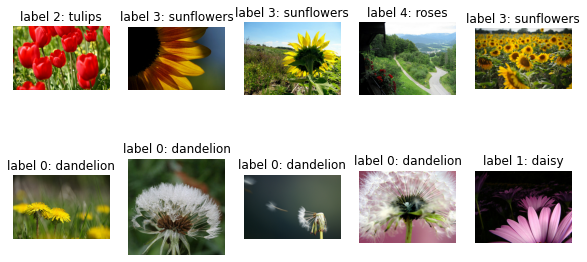

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

이미지를 같은 크기로 formatting 하기

In [ ]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image/255.0) # 픽셀값의 scale 수정
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


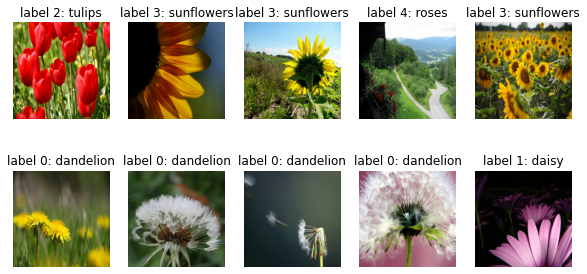

In [ ]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)

    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

train_batches, validation_batches, test_batches 만들기

In [ ]:
# 한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정해주겠습니다.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# train_batches, validation_batches, test_batches를 만들어 주겠습니다.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Step 3. 모델 설계하기

In [ ]:
# basemodel을 활용하여 모델 설계
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG16 활용
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
base_model.trainable = False

# 모델 정의
# 처음에 모델을 학습시킨 결과 정확도가 83% 대에서 맴돌아서 어떻게 해야할지 고민을 하고 있었다.
# 그 중 batchnomalization과 dropout이 떠올라 이를 이용하기로 했고 결과적으로 정확도가 85% 이상으로 올라가는 결과를 얻을 수 있었다.
# 다만 epoch에 따라 val_accuracy값이 눈에 띄게 증가하는 모습은 보이지 않았다.

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(256, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(128, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(64, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(32, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋에서는 class의 갯수가 5가지
])

## Step 4. 모델 학습시키기

In [ ]:
# 모델 학습
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',   # 다중분류이기 때문에 sparse_categorical_crossentropy 사용
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=20, # epochs를 20으로 증가
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 17s 157ms/step - loss: 2.1363 - accuracy: 0.2721 - val_loss: 1.5013 - val_accuracy: 0.3787
Epoch 2/20
92/92 [==============================] - 15s 152ms/step - loss: 1.6563 - accuracy: 0.3617 - val_loss: 1.3253 - val_accuracy: 0.4469
Epoch 3/20
92/92 [==============================] - 15s 155ms/step - loss: 1.3800 - accuracy: 0.4482 - val_loss: 1.0871 - val_accuracy: 0.6158
Epoch 4/20
92/92 [==============================] - 15s 158ms/step - loss: 1.2496 - accuracy: 0.5065 - val_loss: 0.8812 - val_accuracy: 0.6921
Epoch 5/20
92/92 [==============================] - 15s 155ms/step - loss: 1.1119 - accuracy: 0.5603 - val_loss: 0.7738 - val_accuracy: 0.7248
Epoch 6/20
92/92 [==============================] - 15s 153ms/step - loss: 1.0121 - accuracy: 0.6131 - val_loss: 0.7162 - val_accuracy: 0.7548
Epoch 7/20
92/92 [==============================] - 14s 151ms/step - loss: 0.9434 - accuracy: 0.6642 - val_loss: 0.6588 - val_accuracy: 0.7657

## Step 5. 모델 성능 평가하기

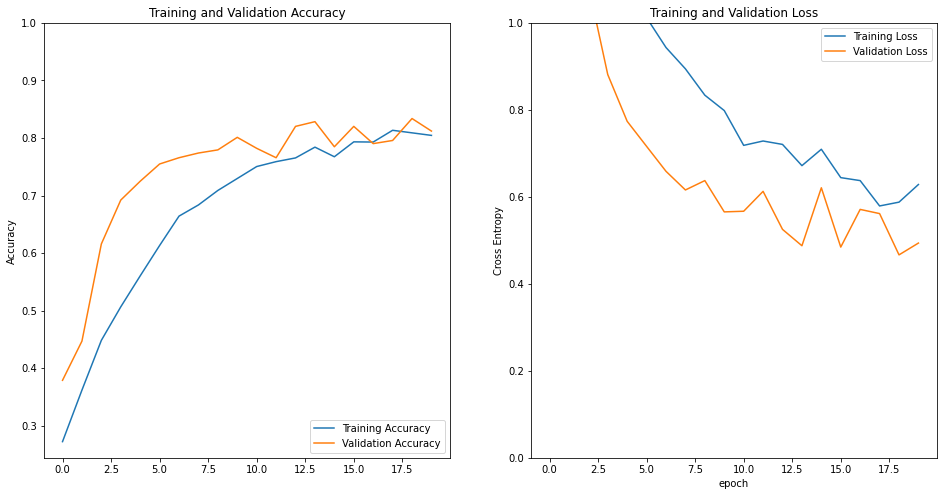

In [ ]:
# 그래프 그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 각 이미지의 예측 값
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.55216828e-02, 1.66640691e-02, 8.97687733e-01, 9.72871669e-03,
        6.03978075e-02],
       [9.99703348e-01, 1.27211082e-04, 4.92680920e-05, 9.37271543e-05,
        2.64505215e-05],
       [7.57620394e-01, 5.24953641e-02, 2.41237488e-02, 1.46031275e-01,
        1.97292324e-02],
       [2.44236994e-03, 4.15971596e-03, 8.68439674e-01, 2.96753645e-03,
        1.21990666e-01],
       [9.62942481e-01, 2.09239461e-02, 5.30421268e-03, 6.38929754e-03,
        4.44000028e-03],
       [9.86933172e-01, 3.71522410e-03, 1.84424350e-03, 6.35224488e-03,
        1.15527469e-03],
       [1.02626719e-01, 2.63502270e-01, 3.06998909e-01, 5.96913323e-02,
        2.67180800e-01],
       [3.94515656e-02, 8.57908189e-01, 9.24704596e-03, 8.17250907e-02,
        1.16680292e-02],
       [1.01101212e-02, 3.81890684e-03, 1.44106457e-02, 9.64781702e-01,
        6.87873457e-03],
       [9.99479353e-01, 2.55279505e-04, 7.04054910e-05, 1.54083740e-04,
        4.08743726e-05],
       [9.86495793e-01, 5.4678

In [ ]:
# 예측 결과
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 1, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

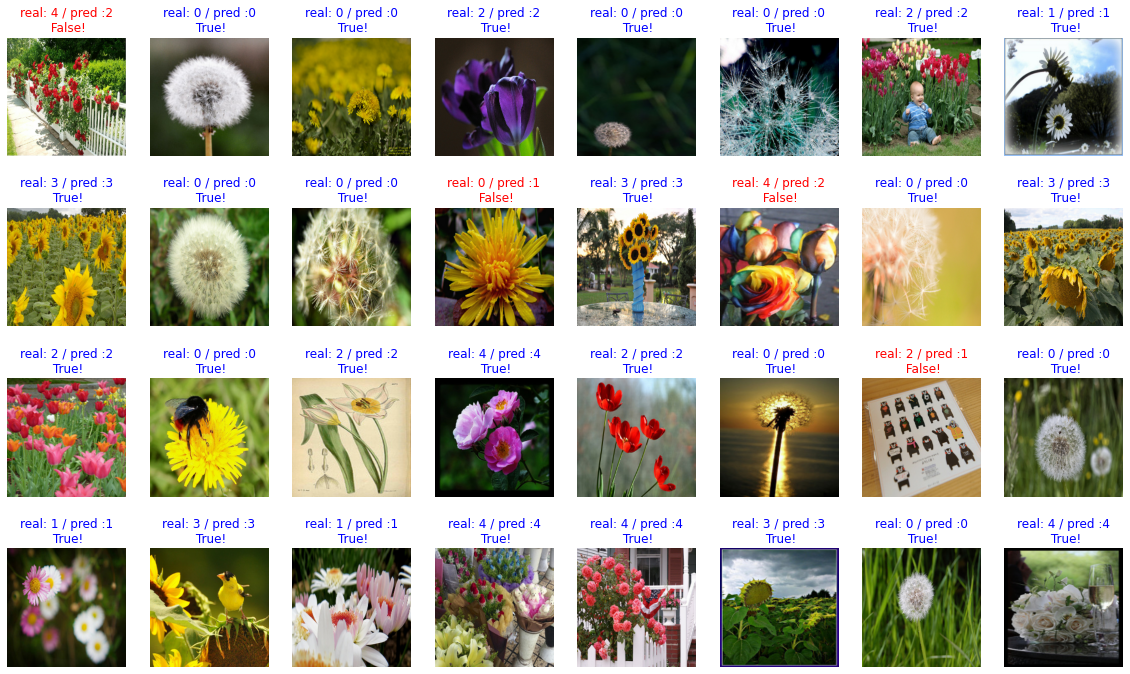

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
# 위의 32개에 대하여 최종 정확도

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

87.5


## 회고
이 활동을 통해 전이 학습이 전체적인 모델의 학습에 얼마나 영향을 미치는지를 배웠습니다. 모델 개선을 위해 정규화, 드롭아웃, 레이어 추가와 같은 전략을 사용할 수 있음을 깨달았습니다. 하지만 하이퍼파라미터 튜닝에 있어서는 어떻게 해야할지 감을 잡지 못한 것 같습니다. 모델을 완성했다고 해서 끝나는 것이 아니라 더 좋은 방법은 없는지 끊임없이 생각하고 조사해 보는 것이 학습에 큰 도움이 된다는 것을 느꼈습니다. 연습과 실험을 통해 모델에 대해 이해가 가지 않는 부분이 없는지 점검하면서 지속적인 학습이 필요하다는 것을 깨달았습니다.